Univariate on close price series (1m to make training shorter and overfit). Just will run longer than v1

In [2]:
#======Core============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import EarlyStopping
import torch
#======Darts===========
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.dataprocessing import Pipeline
#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
#from ue.uexp.dataprocessing.ta import *
#from ue.uexp.models.util import *
#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta

import warnings
warnings.filterwarnings('ignore')

# Data Processing

In [3]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2021-12-31"
time_interval = "1m"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

In [4]:
df.head()

,time,open,high,low,close,volume,adj_close,tic
0,2021-12-30 00:00:00,46761.93,46775.34,46747.15,46768.36,18.86475,46768.36,BTCUSDT
1,2021-12-30 00:01:00,46768.35,46768.36,46746.09,46756.41,17.64987,46756.41,BTCUSDT
2,2021-12-30 00:02:00,46756.41,46765.87,46742.36,46752.86,7.44316,46752.86,BTCUSDT
3,2021-12-30 00:03:00,46752.86,46768.35,46741.94,46762.44,14.16629,46762.44,BTCUSDT
4,2021-12-30 00:04:00,46762.43,46776.73,46756.16,46776.73,12.20940,46776.73,BTCUSDT


In [5]:
# for non 1m data
# df.drop(["tic", "adj_close"], axis=1, inplace=True)
# df['time'] = pd.to_datetime(df['time'])
# df.set_index('time', inplace=True)


In [6]:
df = df[['close']]

In [7]:
df.shape

(999, 1)

In [8]:
dfts = TimeSeries.from_dataframe(df)

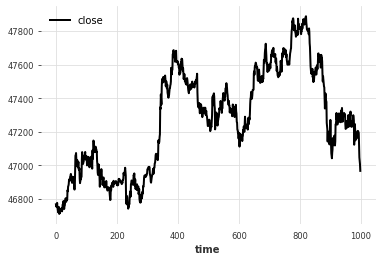

In [9]:
dfts.plot()

In [10]:
type(dfts)

darts.timeseries.TimeSeries

In [11]:
scaler = Scaler()
# [0] because singular
train_og, val_og = dfts.split_after(0.8)
scaled_series = scaler.fit_transform(dfts)
train, val = scaled_series.split_after(0.8)

## Model

In [12]:
model = NBEATSModel(input_chunk_length=60, output_chunk_length=15, random_state=42)

In [13]:
#series = 
model.fit(
    series=train, 
    # val_series=scaled_val_target, 
    epochs=1000, 
    verbose=True)

[2022-02-22 13:33:15,677] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 725 samples.
[2022-02-22 13:33:15,677] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 725 samples.
[2022-02-22 13:33:15,677] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 725 samples.
[2022-02-22 13:33:15,755] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 13:33:15,755] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 13:33:15,755] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-22 13:33:15,757] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity wit

Training: 0it [00:00, ?it/s]

In [14]:
# training was for horizon=15, if predict here horizon>15 then need historic_future_covs
pred_train = model.predict(series=train, n=15)

Predicting: 23it [00:00, ?it/s]

In [15]:
# scale back:
pred_train_scaled = scaler.inverse_transform(pred_train)

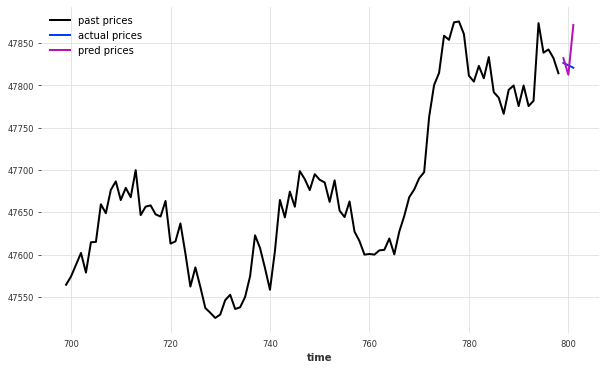

In [22]:
plt.figure(figsize=(10, 6))
# prev train
train_og[-100:].plot(label="past prices")
#actual
val_og[:3].plot(label="actual prices")
# pred
pred_train_scaled[:3].plot(label="pred prices")

In [20]:
model.save_model("small_success.pth.tar")

## Historical Forecast

In [17]:
hist_for = model.historical_forecasts(
    series=train,
    start=0.95, #just the last 5 percent
    forecast_horizon=15,
    #stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/27 [00:00<?, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

Predicting: 23it [00:00, ?it/s]

In [18]:
# rescale
# scale back:
hist_for = scaler.inverse_transform(hist_for)

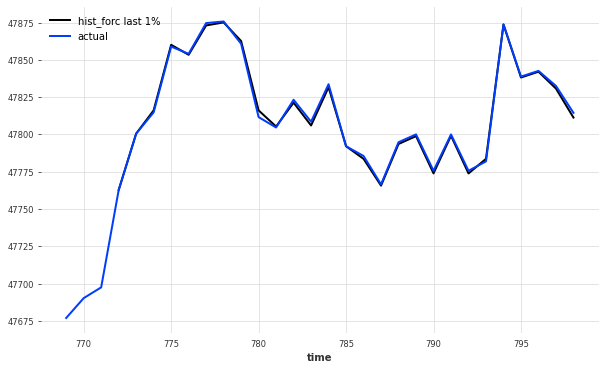

In [19]:
plt.figure(figsize=(10, 6))
hist_for.plot(label="hist_forc last 1%")
train_og[-30:].plot(label="actual")